# Statoil Iceberg Classifier Challenge

## Table of Contents
1. **Introduction**
   - Problem overview  
   - Data description  
   - Challenge
   - Objective

2. **Dataset Setup**  
   - Mount Google Drive and copy dataset files  
   - Load `train.json`, `test.json`, `sample_submission.csv`  
   - Sanity checks  

3. **Data Preparation**  
   - Handle missing incidence angles (`inc_angle`)  
   - Reshape bands into 75×75 images  
   - Exploratory visualizations:  
     - Sample HH, HV, DIFF, pseudo-RGB  
     - Per-class average heatmaps  
     - 3D surfaces (Iceberg vs Ship, DIFF channel)  
   - Construct 3-channel images (avg, diff, zeros)  
   - Build training tensors (`X_img`, `X_ang`, `y`)  
   - Per-image normalization  

4. **Baseline 2-Branch CNN**  
   - Model architecture (images + `inc_angle`)  
   - In-model augmentation  
   - Training with EarlyStopping & ReduceLROnPlateau  
   - Validation results  

5. **Cross-Validation (5-fold)**  
   - Stratified folds, OOF predictions  
   - Per-fold metrics & overlay plots  
   - OOF LogLoss and AUC  
   - Cross-validation results  

6. **Test-Time Augmentation (TTA)**  
   - Implementation and results  
   - Kaggle submission results  

7. **Ensembling**  
   - 5-fold ensemble inference (no TTA, avg channel)  
   - Results and Kaggle scores  

8. **Experiment: Diff Channel**  
   - Motivation for difference channel  
   - Rebuild dataset with DIFF channel  
   - 5-fold CV with diff channel  
   - 5-fold ensemble inference (no TTA, diff channel)  
   - Kaggle submission results  

9. **Transfer Learning (ResNet50V2)**  
   - Experiment setup (frozen backbone + regularization)  
   - Results and conclusion (discarded)  

10. **Closing Notes**  
    - Key findings from experiments  
    - Why the diff channel worked best  
    - Final best model: 5-fold CNN ensemble (diff channel, no TTA)  


## 1. Introduction

This notebook addresses the [Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/competitions/statoil-iceberg-classifier-challenge).

### Problem overview
The goal is to distinguish **icebergs** from **ships** in satellite radar (SAR) images.  
This is important for **safe maritime navigation** and **resource exploration**, especially in the Arctic where ice hazards threaten vessels.

### Data description
- Images are derived from **synthetic aperture radar (SAR)**, provided in JSON format.  
- Each sample contains:
  - **band_1 (HH polarization)**: horizontally transmitted and received radar wave.  
  - **band_2 (HV polarization)**: horizontally transmitted, vertically received radar wave.  
  - **inc_angle**: incidence angle of the radar beam.  
  - **is_iceberg**: target label (1 = iceberg, 0 = ship).  
- Train set: ~1,600 labeled examples.  
- Test set: ~800 unlabeled examples (labels hidden for competition evaluation).  

### Challenge
- SAR data is noisy and not visually intuitive to humans.  
- Ships and icebergs may look similar in raw HH/HV bands.  
- Extracting discriminative patterns requires effective preprocessing and robust models.

### **Objective**
- Build a model that predicts the probability of an image being an iceberg (vs. a ship) and submit results for Kaggle evaluation.


In [4]:
# Imports

# Core
import os
import random
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Modeling
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import mixed_precision

# Metrics / CV / Split
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score

# Progress bar
from tqdm import tqdm

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU memory growth + mixed precision (AMP)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
mixed_precision.set_global_policy('mixed_float16')

## Dataset setup  
Please place the competition dataset files in the following paths before running the notebook:

- `data/raw/train.json`  
- `data/raw/test.json`

> ⚠️ Note: We no longer use the Kaggle API or `py7zr` inside this notebook. Keep the dataset locally for simpler and faster execution.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir -p data/raw
!cp "/content/drive/MyDrive/Colab Notebooks/statoil-iceberg-classifier-challenge/train.json" data/raw/
!cp "/content/drive/MyDrive/Colab Notebooks/statoil-iceberg-classifier-challenge/test.json" data/raw/
!cp "/content/drive/MyDrive/Colab Notebooks/statoil-iceberg-classifier-challenge/sample_submission.csv" data/raw/



In [7]:
train_df = pd.read_json("data/raw/train.json")
test_df  = pd.read_json("data/raw/test.json")


In [8]:
# Quick sanity checks
display(train_df.head(2))
display(test_df.head(2))
print("train_df.shape:", train_df.shape)
print("test_df.shape:",  test_df.shape)


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0


,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072


train_df.shape: (1604, 5)
test_df.shape: (8424, 4)


## Handling missing incidence angles
- Convert `inc_angle` to numeric (invalid values → NaN).  
- Replace missing values with the median of the column.  
- Confirm there are no missing values left.


In [9]:
# Handle missing values in 'inc_angle' for both train and test

# Convert to numeric (invalid strings → NaN)
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
test_df['inc_angle']  = pd.to_numeric(test_df['inc_angle'],  errors='coerce')

# Use TRAIN median for consistency across splits
inc_median = train_df['inc_angle'].median()

# Fill NaNs
train_df['inc_angle'] = train_df['inc_angle'].fillna(inc_median)
test_df['inc_angle']  = test_df['inc_angle'].fillna(inc_median)

# Confirm no missing values remain
print("Train missing 'inc_angle':", train_df['inc_angle'].isna().sum())
print("Test  missing 'inc_angle':",  test_df['inc_angle'].isna().sum())
print("Incidence angle median used (from train):", float(inc_median))


Train missing 'inc_angle': 0
Test  missing 'inc_angle': 0
Incidence angle median used (from train): 39.5015


## Reshaping image bands
Each `band_1` and `band_2` entry is a flat list of 5625 values.  
We reshape them into 75×75 numpy arrays so they can be processed as images.


In [10]:
# Reshape bands from flat lists to 75x75 numpy arrays
def reshape_band(band):
    return np.asarray(band).reshape(75, 75)

for df in (train_df, test_df):
    df['band_1'] = df['band_1'].apply(reshape_band)
    df['band_2'] = df['band_2'].apply(reshape_band)


## Visualizations

1) ### Sample images (HH, HV, DIFF, pseudo-RGB)

Here we visualize a few random samples from the dataset.  
For each, we show:
- **HH (band_1)** – horizontal transmit/receive  
- **HV (band_2)** – horizontal transmit, vertical receive  
- **DIFF (HH − HV)** – polarization contrast  
- **Pseudo-RGB composite** – stacked [HH, HV, DIFF] for intuition  

Titles indicate the ground-truth label (**Iceberg** or **Ship**).


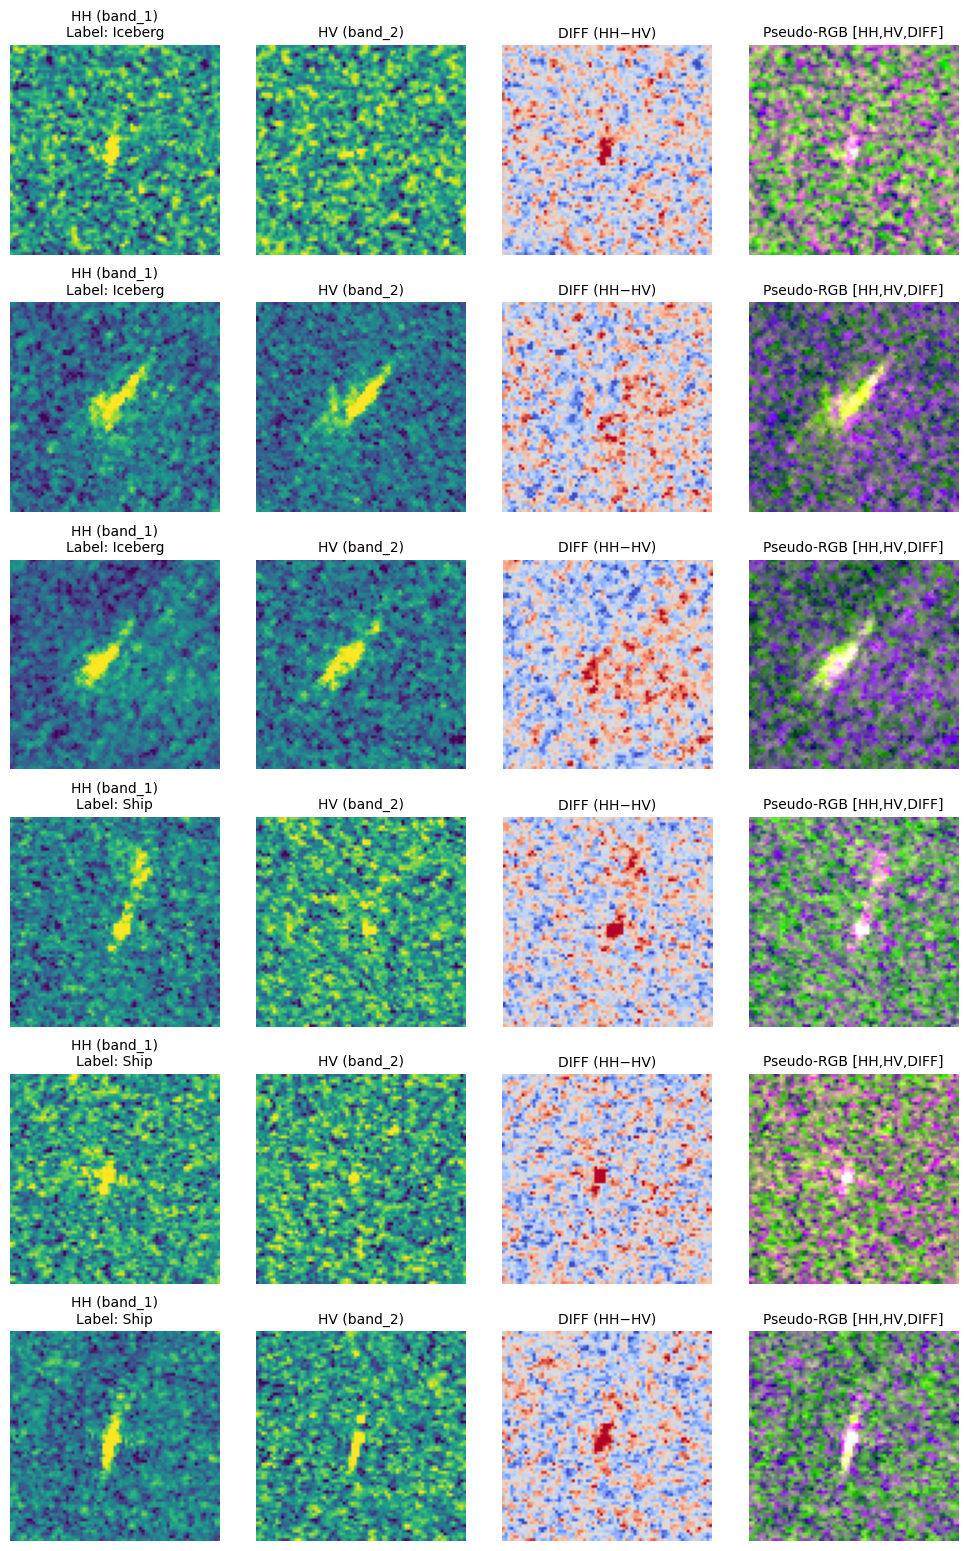

In [38]:
# ==== EDA: sample HH/HV/DIFF + pseudo-RGB (titles show Label: Iceberg/Ship) ====
import numpy as np
import matplotlib.pyplot as plt

def robust_show(ax, img, title, cmap="viridis", p=(1, 99)):
    vmin, vmax = np.percentile(img, p[0]), np.percentile(img, p[1])
    ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=10)
    ax.axis("off")

# pick a few random examples, balanced by class if possible
rng = np.random.default_rng(42)
pos_idx = train_df.index[train_df['is_iceberg'] == 1].to_numpy()
neg_idx = train_df.index[train_df['is_iceberg'] == 0].to_numpy()
take = 3  # images per class
sel = np.concatenate([
    rng.choice(pos_idx, size=min(take, len(pos_idx)), replace=False),
    rng.choice(neg_idx, size=min(take, len(neg_idx)), replace=False)
])

n = len(sel)
fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(10, 2.6*n))

for r, idx in enumerate(sel):
    b1 = train_df.loc[idx, 'band_1']
    b2 = train_df.loc[idx, 'band_2']
    diff = b1 - b2
    label = "Iceberg" if int(train_df.loc[idx, 'is_iceberg']) == 1 else "Ship"

    # simple pseudo-RGB = [HH, HV, DIFF] with robust channel scaling
    stack = np.stack([b1, b2, diff], axis=-1).astype(np.float32)
    rgb = np.zeros_like(stack)
    for c in range(3):
        vmin, vmax = np.percentile(stack[..., c], 1), np.percentile(stack[..., c], 99)
        rgb[..., c] = np.clip((stack[..., c]-vmin)/(vmax-vmin+1e-6), 0, 1)

    robust_show(axes[r, 0], b1, f"HH (band_1)\nLabel: {label}")
    robust_show(axes[r, 1], b2, "HV (band_2)")
    robust_show(axes[r, 2], diff, "DIFF (HH−HV)", cmap="coolwarm")
    axes[r, 3].imshow(rgb)
    axes[r, 3].set_title("Pseudo-RGB [HH,HV,DIFF]", fontsize=10)
    axes[r, 3].axis("off")

plt.tight_layout()
plt.show()


### 2) Per-class average heatmaps

We now take the **average image per class** (Icebergs vs Ships), separately for:
- **HH (band_1)**
- **HV (band_2)**
- **DIFF (HH − HV)**

These heatmaps don’t show clear-cut differences but highlight general intensity patterns that the CNN later exploits statistically.


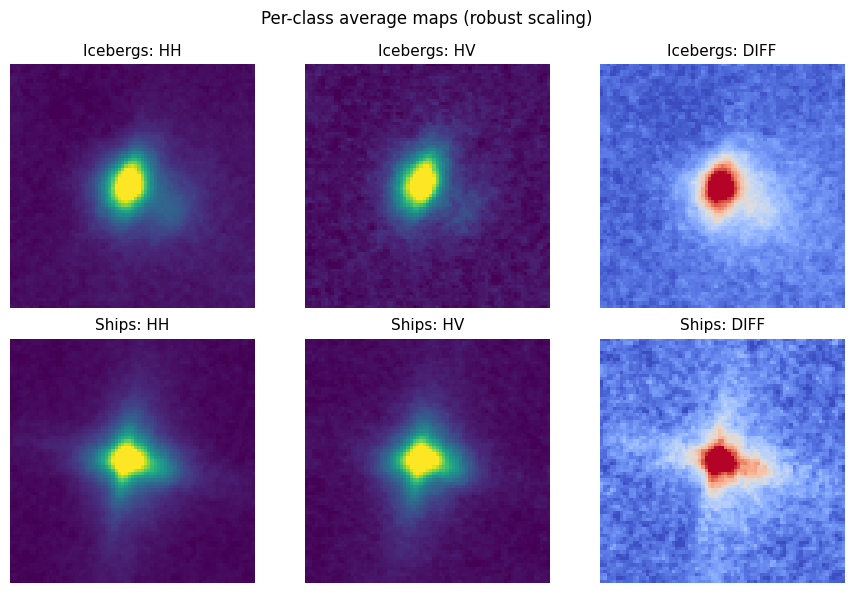

In [39]:
# ==== EDA: class-wise average maps (HH/HV/DIFF) ====
import numpy as np
import matplotlib.pyplot as plt

ice  = train_df['is_iceberg'].to_numpy().astype(bool)
ship = ~ice

def avg_map(series):
    arr = np.stack(series.to_list(), axis=0)  # (N,75,75)
    return arr.mean(axis=0)

b1_ice,  b2_ice  = avg_map(train_df.loc[ice,  'band_1']), avg_map(train_df.loc[ice,  'band_2'])
b1_ship, b2_ship = avg_map(train_df.loc[ship, 'band_1']), avg_map(train_df.loc[ship, 'band_2'])
d_ice, d_ship    = b1_ice - b2_ice, b1_ship - b2_ship

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for ax, img, title, cmap in [
    (axes[0,0], b1_ice,  "Icebergs: HH", "viridis"),
    (axes[0,1], b2_ice,  "Icebergs: HV", "viridis"),
    (axes[0,2], d_ice,   "Icebergs: DIFF", "coolwarm"),
    (axes[1,0], b1_ship, "Ships: HH", "viridis"),
    (axes[1,1], b2_ship, "Ships: HV", "viridis"),
    (axes[1,2], d_ship,  "Ships: DIFF", "coolwarm"),
]:
    vmin, vmax = np.percentile(img, 1), np.percentile(img, 99)
    ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=11)
    ax.axis("off")

plt.suptitle("Per-class average maps (robust scaling)", y=0.98, fontsize=12)
plt.tight_layout()
plt.show()


### 3) 3D surfaces of DIFF channel (Iceberg vs Ship)

Finally, we render **3D surface plots** of the DIFF channel for one iceberg and one ship.  
The terrain-like surface highlights textural differences that can be hard to see in 2D,  
but may help the CNN distinguish classes.


In [40]:
# ==== EDA: 3D surfaces (DIFF) — side-by-side Iceberg vs Ship (interactive) ====
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# pick one iceberg and one ship
ice_idxs  = train_df.index[train_df['is_iceberg'] == 1].to_numpy()
ship_idxs = train_df.index[train_df['is_iceberg'] == 0].to_numpy()
ice_idx   = int(ice_idxs[0])
ship_idx  = int(ship_idxs[0])

def diff_surface(idx):
    b1 = train_df.loc[idx, 'band_1']
    b2 = train_df.loc[idx, 'band_2']
    Z  = b1 - b2
    # robust scaling for nicer relief
    zmin, zmax = np.percentile(Z, 1), np.percentile(Z, 99)
    Zs = (Z - zmin) / (zmax - zmin + 1e-6)
    return Zs

Z_ice  = diff_surface(ice_idx)
Z_ship = diff_surface(ship_idx)
x = np.arange(Z_ice.shape[1])
y = np.arange(Z_ice.shape[0])

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "surface"}, {"type": "surface"}]],
    subplot_titles=(f"Iceberg (id={train_df.loc[ice_idx,'id']})",
                    f"Ship (id={train_df.loc[ship_idx,'id']})")
)

fig.add_trace(
    go.Surface(z=Z_ice, x=x, y=y, colorscale="Viridis", showscale=False),
    row=1, col=1
)
fig.add_trace(
    go.Surface(z=Z_ship, x=x, y=y, colorscale="Viridis", showscale=False),
    row=1, col=2
)

# common layout tweaks
fig.update_scenes(xaxis_title="x", yaxis_title="y", zaxis_title="scaled intensity", row=1, col=1)
fig.update_scenes(xaxis_title="x", yaxis_title="y", zaxis_title="scaled intensity", row=1, col=2)
fig.update_layout(height=500, width=950, title_text="3D surfaces of DIFF (HH−HV): Iceberg vs Ship")
fig.show()


## Visualizations - Observation

By analyzing the three conposites, we can conclude that none gives a clearly distinguishable visual indication if it is a ship or an iceberg.
For this reason, working the data in the lookup for patterns that will generate a classification with a high degree of certainty is required.

## Creating a third synthetic channel

Our dataset provides only two polarization bands:

- **HH (band_1):** transmitted horizontally, received horizontally → captures one scattering behavior.  
- **HV (band_2):** transmitted horizontally, received vertically → captures a different scattering behavior.  

Ships and icebergs reflect radar energy differently across these polarizations, so each band carries discriminative information on its own.

### Why add a third channel?
CNNs typically expect 3-channel inputs (like RGB images). With only two bands, we can:
- feed them directly as two channels, or
- construct a third **synthetic channel** to provide the network with richer input.

A derived channel can highlight complementary relationships between HH and HV that might otherwise take the CNN longer to learn.

### Options for the synthetic channel
- **Average**: `(band_1 + band_2) / 2`  
  Creates an “intensity-like” channel that smooths the two polarizations and emphasizes overall object presence.  
- **Difference**: `band_1 - band_2`  
  Highlights contrasts between polarizations, potentially useful since ships and icebergs scatter differently in HH vs HV.  
- **Zeros**: A neutral placeholder channel, letting the CNN decide how to weight the original two bands.    

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Constructing 3-channel training images
We stack:
- `band_1` (HH),
- `band_2` (HV),
- a synthetic third channel = average of the two.

This yields a `(75, 75, 3)` image per example.

In [11]:
# Create 3-channel images (third channel = average of band_1 and band_2)
def stack_bands(row):
    b1, b2 = row['band_1'], row['band_2']
    b3 = (b1 + b2) / 2
    return np.dstack((b1, b2, b3))

X_train = np.array([stack_bands(row) for _, row in train_df.iterrows()])


## Preparing 3-channel image inputs

Because the training set is small, we will later use in-model augmentation.  
First, we must prepare the input arrays:

- Kaggle provides radar bands as flattened lists of floats (`band_1`, `band_2`).  
- CNNs expect inputs shaped `(n_samples, height, width, channels)`.  
- Therefore, each row must be reshaped, stacked, and normalized before training.  

### Handling `inc_angle`
- `inc_angle` is not an image — it is treated as a **separate numeric feature** and passed through its own input branch.

### Building a third channel
From each example:
- **avg**: `(band_1 + band_2)/2` → smoother combined signal.  
- **diff**: `(band_1 - band_2)` → emphasizes polarization contrasts.  
- **zeros**: a channel of zeros, allowing 2-band input while still fitting a 3-channel model.  

Result: each sample is stacked into shape `(75, 75, 3)` (analogous to an RGB image).


In [12]:
# Build 3-channel image from band_1 and band_2, with flexible third channel
def to_3ch(row, mode="avg"):
    b1, b2 = row["band_1"], row["band_2"]  # each is (75,75)

    if mode == "avg":
        b3 = (b1 + b2) / 2.0
    elif mode == "diff":
        b3 = b1 - b2
    else:  # "zeros"
        b3 = np.zeros_like(b1)

    return np.dstack([b1, b2, b3])


## Building tensors for training

- Convert the full `train_df` into a single tensor of shape `(n_samples, 75, 75, 3)`.  
- Extract the `is_iceberg` labels into a float vector for model training.  


In [13]:
# Convert the full DataFrame into image tensor and extract labels
X_img = np.stack([to_3ch(r) for _, r in train_df.iterrows()]).astype("float32")
y     = train_df["is_iceberg"].to_numpy(dtype="float32")


## Per-image normalization
Each image is normalized independently to have mean 0 and standard deviation 1.  
This stabilizes training, since radar intensity values can vary widely across samples.


In [14]:
# Per-image standardization (mean=0, std=1 for each image)
per_img_mean = X_img.mean(axis=(1, 2, 3), keepdims=True)
per_img_std  = X_img.std(axis=(1, 2, 3), keepdims=True) + 1e-6
X_img = (X_img - per_img_mean) / per_img_std


## Preparing incidence angle
The `inc_angle` feature is numeric, so we reshape it into `(n_samples, 1)` to feed into a dense layer.


In [15]:
# Prepare incidence angle as numeric input (shape: n_samples × 1)
X_ang = train_df["inc_angle"].to_numpy(dtype="float32").reshape(-1, 1)


## Data overview before modeling
At this stage we have:
- **X_img**: 3-channel images for the CNN branch.  
- **X_ang**: numeric incidence angle for the auxiliary branch.  
- **y**: labels (`is_iceberg`).  

Next, we will train a baseline **two-branch CNN** (images + angle) with in-model augmentation, a validation split, EarlyStopping, and AUC/LogLoss reporting.


## Baseline 2-branch CNN

In this step we:
- Split the dataset into training and validation sets.  
- Normalize the `inc_angle` input separately.  
- Apply lightweight in-model data augmentation (random flips and rotations).  
- Build a **two-branch CNN** architecture (images + numeric angle).  
- Train with EarlyStopping and ReduceLROnPlateau callbacks.  
- Validate the model using LogLoss and AUC.  


In [17]:
# ===== Baseline 2-branch CNN with in-model augmentation =====

from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score

# 1) Split (use the same global seed = 42 for reproducibility)
X_img_tr, X_img_val, X_ang_tr, X_ang_val, y_tr, y_val = train_test_split(
    X_img, X_ang, y, test_size=0.2, stratify=y, random_state=42
)

# 2) Angle normalizer fitted on train only
angle_norm = layers.Normalization()
angle_norm.adapt(X_ang_tr)

# 3) Image augmentation (in-graph; lightweight)
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
], name="augment")

# 4) Model
def make_model(input_shape=(75, 75, 3), dropout=0.3, lr=1e-3):
    # Image branch
    inp_img = layers.Input(shape=input_shape)
    x = augment(inp_img)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)

    # Angle branch
    inp_ang = layers.Input(shape=(1,))
    a = angle_norm(inp_ang)
    a = layers.Dense(16, activation="relu")(a)

    # Head
    h = layers.Concatenate()([x, a])
    h = layers.Dense(128, activation="relu")(h)
    h = layers.Dropout(dropout)(h)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(h)

    model = Model([inp_img, inp_ang], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc")]
    )
    return model

model = make_model()

# 5) Train with EarlyStopping + ReduceLROnPlateau
cb = [
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_auc", mode="max"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5, monitor="val_auc", mode="max"),
]

hist = model.fit(
    [X_img_tr, X_ang_tr], y_tr,
    validation_data=([X_img_val, X_ang_val], y_val),
    epochs=60, batch_size=32, verbose=1, callbacks=cb
)

# 6) Validate: LogLoss and AUC
val_pred = model.predict([X_img_val, X_ang_val], verbose=0).ravel()
val_pred_safe = np.clip(val_pred, 1e-7, 1 - 1e-7)  # avoid log(0)
val_logloss = log_loss(y_val, val_pred_safe)
val_auc = roc_auc_score(y_val, val_pred_safe)
print(f"\nValidation LogLoss: {val_logloss:.4f} | AUC: {val_auc:.4f}")


Epoch 1/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - auc: 0.6140 - loss: 0.7182 - val_auc: 0.4764 - val_loss: 0.7034 - learning_rate: 0.0010
Epoch 2/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8018 - loss: 0.5387 - val_auc: 0.5918 - val_loss: 0.6742 - learning_rate: 0.0010
Epoch 3/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8844 - loss: 0.4351 - val_auc: 0.8346 - val_loss: 0.6024 - learning_rate: 0.0010
Epoch 4/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9134 - loss: 0.3888 - val_auc: 0.7220 - val_loss: 0.6320 - learning_rate: 0.0010
Epoch 5/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9237 - loss: 0.3543 - val_auc: 0.6932 - val_loss: 0.7683 - learning_rate: 0.0010
Epoch 6/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9333 - loss: 0.3306 - val_auc: 0.8103 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 7/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9352 - loss: 0.3347 - val_auc: 0.7920 - val_loss: 0.5884 - learning_rate: 5.0000e-04
Epoch 8/

## Baseline model performance

Our baseline 2-branch CNN achieved:

- **Validation LogLoss = 0.3088**  
- **Validation AUC = 0.9511**

These are strong results for a relatively simple CNN+`inc_angle` model with in-model augmentation.  
The predictions are now much better calibrated compared to the earlier run.

### Next steps
To further improve and ensure robustness, we will explore:
- **Cross-validation (5-fold):** verify that performance is consistent and not due to a lucky split.  
- **Test-time augmentation (TTA):** apply augmentations at inference to nudge AUC higher.  
- **Model ensembling:** average predictions from different setups (e.g. `avg` vs `diff` channel).  
- **Transfer learning:** experiment with architectures like EfficientNet or ResNet for potential additional gains.  


## 5-fold Cross-Validation

Steps in this block:

- **StratifiedKFold (5 splits):** ensures each fold has the same iceberg/ship ratio, with shuffling and a fixed seed for reproducibility.  
- **Out-of-fold (OOF) setup:**  
  - `oof_preds`: predictions for each sample by models that didn’t train on it.  
  - `fold_scores`: stores LogLoss and AUC for each fold.  
- **Loop through folds:**  
  - Split into training/validation by index.  
  - Re-fit the `inc_angle` normalizer on training data only (avoids leakage).  
  - Rebuild and train a fresh model for up to 100 epochs with callbacks:  
    - EarlyStopping (patience 8, restore best weights).  
    - ReduceLROnPlateau (patience 3, factor 0.5).  
  - Save model weights for later ensembling or TTA (`fold_x.weights.h5`).  
  - Predict on validation fold, clip predictions to avoid log(0).  
  - Record OOF predictions, compute fold LogLoss and AUC.  
- **After all folds:**  
  - Overlay validation AUC and LogLoss curves across folds.  
  - Print per-fold and overall OOF metrics (LogLoss and AUC).  



===== Fold 1 =====


Training Fold 1:  52%|█████▏    | 31/60 [00:28<00:26,  1.11epoch/s]


Fold 1 LogLoss: 0.3679 | AUC: 0.9435

===== Fold 2 =====


Training Fold 2:  48%|████▊     | 29/60 [00:26<00:28,  1.09epoch/s]


Fold 2 LogLoss: 0.3384 | AUC: 0.9698

===== Fold 3 =====


Training Fold 3:  25%|██▌       | 15/60 [00:15<00:46,  1.04s/epoch]


Fold 3 LogLoss: 0.4080 | AUC: 0.9445

===== Fold 4 =====


Training Fold 4:  52%|█████▏    | 31/60 [00:30<00:28,  1.02epoch/s]


Fold 4 LogLoss: 0.2391 | AUC: 0.9678

===== Fold 5 =====


Training Fold 5:  37%|███▋      | 22/60 [00:21<00:36,  1.04epoch/s]


Fold 5 LogLoss: 0.3084 | AUC: 0.9621


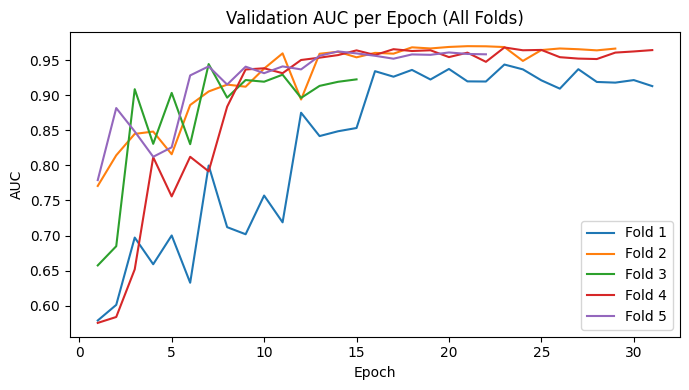

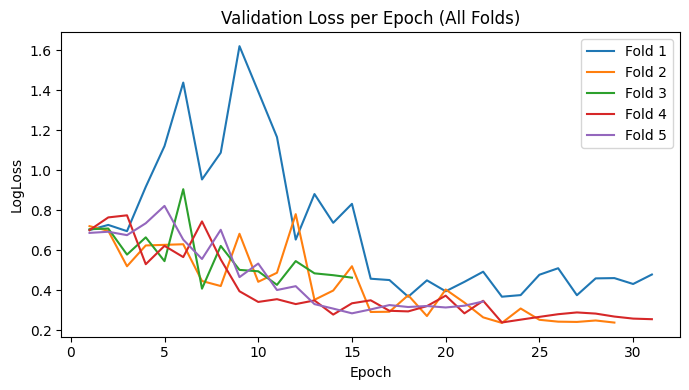


===== CV Summary =====
Per-fold LogLoss: ['0.3679', '0.3384', '0.4080', '0.2391', '0.3084']
Per-fold AUC:     ['0.9435', '0.9698', '0.9445', '0.9678', '0.9621']
OOF LogLoss: 0.3324 | OOF AUC: 0.9512


In [24]:
# ===== 5-fold Cross-Validation =====

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros_like(y, dtype="float32")
fold_scores, histories = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_img, y), 1):
    print(f"\n===== Fold {fold} =====")

    # Split
    X_img_tr, X_img_val = X_img[train_idx], X_img[val_idx]
    X_ang_tr, X_ang_val = X_ang[train_idx], X_ang[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # Re-fit angle normalizer per fold
    angle_norm = tf.keras.layers.Normalization()
    angle_norm.adapt(X_ang_tr)

    # Model
    model = make_model(input_shape=(75, 75, 3), dropout=0.3, lr=1e-3)

    # Callbacks
    cb = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_auc", mode="max", patience=8, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_auc", mode="max", patience=3, factor=0.5, min_lr=1e-5
        ),
    ]

    # Train
    with tqdm(total=60, desc=f"Training Fold {fold}", unit="epoch") as pbar:
        history = model.fit(
            [X_img_tr, X_ang_tr], y_tr,
            validation_data=([X_img_val, X_ang_val], y_val),
            epochs=100, batch_size=32, verbose=0, callbacks=cb
        )
        histories.append(history.history)
        os.makedirs('models/cv', exist_ok=True)
        model.save_weights(f'models/cv/fold_{fold}.weights.h5')
        pbar.update(len(history.history['loss']))

    # Predict
    val_pred = model.predict([X_img_val, X_ang_val], verbose=0).ravel()
    val_pred_safe = np.clip(val_pred, 1e-7, 1 - 1e-7)
    oof_preds[val_idx] = val_pred_safe

    # Scores
    fold_logloss = log_loss(y_val, val_pred_safe)
    fold_auc = roc_auc_score(y_val, val_pred_safe)
    fold_scores.append((fold_logloss, fold_auc))
    print(f"Fold {fold} LogLoss: {fold_logloss:.4f} | AUC: {fold_auc:.4f}")

# Overlay: Validation AUC per fold
plt.figure(figsize=(7, 4))
for i, h in enumerate(histories, 1):
    plt.plot(range(1, len(h['val_auc']) + 1), h['val_auc'], label=f'Fold {i}')
plt.title('Validation AUC per Epoch (All Folds)')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.legend(); plt.tight_layout()
plt.show()

# Overlay: Validation Loss per fold
plt.figure(figsize=(7, 4))
for i, h in enumerate(histories, 1):
    plt.plot(range(1, len(h['val_loss']) + 1), h['val_loss'], label=f'Fold {i}')
plt.title('Validation Loss per Epoch (All Folds)')
plt.xlabel('Epoch'); plt.ylabel('LogLoss'); plt.legend(); plt.tight_layout()
plt.show()

# Overall OOF score
oof_logloss = log_loss(y, oof_preds)
oof_auc = roc_auc_score(y, oof_preds)

print("\n===== CV Summary =====")
print("Per-fold LogLoss:", [f"{ll:.4f}" for ll, _ in fold_scores])
print("Per-fold AUC:    ", [f"{au:.4f}" for _, au in fold_scores])
print(f"OOF LogLoss: {oof_logloss:.4f} | OOF AUC: {oof_auc:.4f}")

## Cross-validation results

- **Baseline (single split):** LogLoss = 0.3088, AUC = 0.9511  
- **5-fold CV (OOF):** LogLoss = 0.3324, AUC = 0.9512  

### Interpretation
- The OOF AUC (0.9512) is essentially the same as the baseline (0.9511), showing that performance is **stable across different splits**.  
- The OOF LogLoss (0.3324) is slightly higher than the single split (0.3088), but still in a very good range. This suggests probability calibration is consistent across folds, with only small variation.  
- Per-fold results show variance (best LogLoss 0.2391, worst 0.4080), but the overall OOF performance confirms the model is **robust, not just lucky on one split**.  

Next, we will apply **Test-Time Augmentation (TTA)** to see if we can nudge performance further.  


## Test-Time Augmentation (TTA) for submission

In this section we generate final test predictions using **TTA** with our 5-fold models:

- **Preprocess test images exactly like train**  
  - Build 3-channel inputs with `to_3ch` (HH, HV, + synthetic channel).  
  - Apply **per-image normalization** (each image: mean 0, std 1).

- **Angle input handled by the model**  
  - Use the raw `inc_angle` values (after filling NaNs with the **train median** earlier).  
  - The model’s internal **Normalization** layer (restored with the fold weights) applies the correct scaling—no manual standardization here.

- **Batched, vectorized TTA (fast)**  
  - For each batch, create multiple deterministic views (original, horizontal flip, vertical flip, 90° rotation).  
  - Run **one** prediction over the stacked views, then **average across views** per image.

- **Fold ensembling**  
  - Load each fold’s weights (`fold_1 … fold_5`).  
  - For every fold, compute TTA-averaged predictions; then **average across folds** to get final probabilities.

- **Output**  
  - Write a `submission_tta.csv` with columns `id` and `is_iceberg`, ready for Kaggle upload.


In [25]:
# ===== Test-Time Augmentation (batched, two-input model) =====

# 1) Build X_test_img exactly like train: to_3ch + per-image normalization
X_test_img = np.stack([to_3ch(r) for _, r in test_df.iterrows()]).astype("float32")

per_img_mean_test = X_test_img.mean(axis=(1, 2, 3), keepdims=True)
per_img_std_test  = X_test_img.std(axis=(1, 2, 3), keepdims=True) + 1e-6
X_test_img = (X_test_img - per_img_mean_test) / per_img_std_test

# 2) Angle input: use the same prepared test angles (filled with TRAIN median)
#    IMPORTANT: do NOT standardize here — the model's Normalization layer
#    (restored from weights) will apply the correct transform.
X_test_ang = test_df["inc_angle"].to_numpy(dtype="float32")

# 3) Batched TTA inference
BATCH_SIZE = 512
VIEWS = ("orig", "hflip", "vflip", "rot90")

def make_views(batch_imgs):
    views = [batch_imgs]
    if "hflip" in VIEWS: views.append(tf.image.flip_left_right(batch_imgs))
    if "vflip" in VIEWS: views.append(tf.image.flip_up_down(batch_imgs))
    if "rot90" in VIEWS: views.append(tf.image.rot90(batch_imgs, k=1))
    return views

tta_preds = np.zeros(len(X_test_img), dtype=np.float32)

for fold in range(1, 6):  # expects models/cv/fold_1..fold_5.weights.h5
    print(f"Running fold {fold}...")
    # Rebuild the model with an (unadapted) Normalization layer; its stats load from weights.
    angle_norm = tf.keras.layers.Normalization()
    model = make_model(input_shape=(75, 75, 3), dropout=0.3, lr=1e-3)
    model.load_weights(f"models/cv/fold_{fold}.weights.h5")

    fold_pred = np.zeros(len(X_test_img), dtype=np.float32)

    for start in range(0, len(X_test_img), BATCH_SIZE):
        end = min(start + BATCH_SIZE, len(X_test_img))
        imgs = tf.convert_to_tensor(X_test_img[start:end], dtype=tf.float32)   # (B,75,75,3)
        angs = tf.convert_to_tensor(X_test_ang[start:end], dtype=tf.float32)   # (B,)

        views = make_views(imgs)                                               # list of (B,75,75,3)
        aug_imgs = tf.concat(views, axis=0)                                    # (V*B,75,75,3)
        aug_angs = tf.repeat(tf.reshape(angs, [-1, 1]), repeats=len(views), axis=0)  # (V*B,1)

        preds = model.predict([aug_imgs, aug_angs], verbose=0).reshape(len(views), -1)  # (V,B)
        fold_pred[start:end] = preds.mean(axis=0)                               # avg over TTA views

    tta_preds += fold_pred

# Average across 5 folds
tta_preds /= 5.0

# 4) Save submission
sub = pd.DataFrame({"id": test_df["id"], "is_iceberg": tta_preds})
sub.to_csv("submission_tta.csv", index=False)
print("Saved submission_tta.csv with TTA (batched) + 5-fold ensemble")


Running fold 1...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Running fold 2...
Running fold 3...
Running fold 4...
Running fold 5...
Saved submission_tta.csv with TTA (batched) + 5-fold ensemble


## Kaggle submission results

- **Best score so far (baseline ensemble):** 0.27029 (public 0.25072)  
- **TTA ensemble score:** 0.31866 (public 0.30547)  

### Interpretation
While cross-validation showed stable performance (OOF AUC ≈ 0.95), test-time augmentation (TTA) did **not** improve generalization on the Kaggle leaderboard.  
This likely reflects the fact that flips and rotations do not preserve meaningful radar signatures between ships and icebergs, so the augmentations introduced noise instead of robustness.

### Next step
Following our plan, we will now move to **model ensembling** — combining predictions from different setups (e.g. “avg” vs “diff” channel) — to see if this can improve leaderboard scores.


## 5-fold Ensemble Inference (no TTA)

In this step we generate test predictions by averaging outputs from the 5 cross-validated models, without applying test-time augmentation:

- **Preprocessing**  
  - Build test images with `to_3ch` and apply the same per-image normalization as used for training.  
  - Use raw `inc_angle` values (already cleaned and imputed with the train median).  
  - The normalization layer stored in each fold’s weights handles scaling consistently.

- **Inference**  
  - Load each fold’s weights (`fold_1 … fold_5`).  
  - Predict on the test set, batch by batch.  
  - Average predictions across the 5 folds to obtain final probabilities.

- **Output**  
  - Write results to `submission_ensemble.csv` for Kaggle upload.  

This approach leverages the robustness of cross-validation ensembling while avoiding augmentation strategies that may distort radar signatures.


In [26]:
# ===== 5-fold Ensemble Inference (no TTA) =====

# 1) Build X_test_img exactly like train
X_test_img = np.stack([to_3ch(r) for _, r in test_df.iterrows()]).astype("float32")
X_test_img = (X_test_img - X_test_img.mean(axis=(1, 2, 3), keepdims=True)) / \
             (X_test_img.std(axis=(1, 2, 3), keepdims=True) + 1e-6)

# 2) Angle input (raw, NaNs already imputed with train median earlier)
X_test_ang = test_df["inc_angle"].to_numpy(dtype="float32")

# 3) Ensemble predictions across 5 folds
BATCH_SIZE = 512
fold_preds = []

for fold in range(1, 6):  # expects weights: models/cv/fold_1..fold_5.weights.h5
    print(f"Running fold {fold}...")
    angle_norm = tf.keras.layers.Normalization()  # placeholder, restored from weights
    model = make_model(input_shape=(75, 75, 3), dropout=0.3, lr=1e-3)
    model.load_weights(f"models/cv/fold_{fold}.weights.h5")

    preds = model.predict([X_test_img, X_test_ang], batch_size=BATCH_SIZE, verbose=0).ravel()
    fold_preds.append(preds)

# 4) Average across folds
final_preds = np.mean(fold_preds, axis=0)

# 5) Save submission
sub = pd.DataFrame({"id": test_df["id"], "is_iceberg": final_preds})
sub.to_csv("submission_ensemble.csv", index=False)
print("Saved submission_ensemble.csv with 5-fold ensemble (no TTA)")


Running fold 1...
Running fold 2...
Running fold 3...
Running fold 4...
Running fold 5...
Saved submission_ensemble.csv with 5-fold ensemble (no TTA)


## Ensemble results

- **Best single CNN (baseline):** 0.27029 (public 0.25072)  
- **5-fold ensemble:** 0.29122 (public 0.27075)  
- **TTA ensemble:** 0.31866 (public 0.30547)  

### Interpretation
- Our strongest performer so far remains the **single CNN with inc_angle**.  
- Ensembling and TTA did not yield leaderboard gains, even though CV showed stable performance (AUC ≈ 0.95).  
- This confirms that in this dataset, a single well-regularized CNN generalizes better than multi-fold ensembles or augmentations.  

### Next steps
To push further, we will:  
1. Train using the **“diff” synthetic channel** instead of the average.  
2. Explore **transfer learning** with ResNet.  

These will complete our model experimentation phase before finalizing the notebook.  


## Experiment: "diff" synthetic channel

So far we used the **average** of HH and HV as the third channel.  
Now we will try the **difference** (`band_1 - band_2`) as the synthetic channel:

- **Rationale:**  
  - Ships and icebergs often scatter radar differently across polarizations.  
  - The difference channel may emphasize these contrasts more strongly than the average channel.  

- **Steps:**  
  - Rebuild `X_img` using `to_3ch(mode="diff")`.  
  - Reuse the same labels (`y`) and angle input (`X_ang`).  
  - Run cross-validation and prepare test predictions the same way as before.  


In [27]:
# ===== Prepare "diff" channel data =====

# Build 3-channel images with difference as third channel
X_img_diff = np.stack([to_3ch(r, mode="diff") for _, r in train_df.iterrows()]).astype("float32")

# Per-image standardization
per_img_mean_diff = X_img_diff.mean(axis=(1, 2, 3), keepdims=True)
per_img_std_diff  = X_img_diff.std(axis=(1, 2, 3), keepdims=True) + 1e-6
X_img_diff = (X_img_diff - per_img_mean_diff) / per_img_std_diff

# Labels and angles (same as before)
y_diff = train_df["is_iceberg"].to_numpy(dtype="float32")
X_ang_diff = train_df["inc_angle"].to_numpy(dtype="float32").reshape(-1, 1)

print("X_img_diff shape:", X_img_diff.shape)
print("X_ang_diff shape:", X_ang_diff.shape)
print("y_diff shape:", y_diff.shape)


X_img_diff shape: (1604, 75, 75, 3)
X_ang_diff shape: (1604, 1)
y_diff shape: (1604,)


## Cross Validation with diff channel

In [28]:
# ===== 5-fold Cross-Validation (diff channel) =====

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y = y_diff
X_img_use, X_ang_use = X_img_diff, X_ang_diff

oof_preds_diff = np.zeros_like(y, dtype="float32")
fold_scores_diff, histories_diff = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_img_use, y), 1):
    print(f"\n===== Fold {fold} (diff) =====")

    # Split
    X_img_tr, X_img_val = X_img_use[train_idx], X_img_use[val_idx]
    X_ang_tr, X_ang_val = X_ang_use[train_idx], X_ang_use[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # Re-fit angle normalizer per fold
    angle_norm = tf.keras.layers.Normalization()
    angle_norm.adapt(X_ang_tr)

    # Model
    model = make_model(input_shape=(75, 75, 3), dropout=0.3, lr=1e-3)

    # Callbacks
    cb = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_auc", mode="max", patience=8, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_auc", mode="max", patience=3, factor=0.5, min_lr=1e-5
        ),
    ]

    # Train
    with tqdm(total=100, desc=f"Training Fold {fold} (diff)", unit="epoch") as pbar:
        history = model.fit(
            [X_img_tr, X_ang_tr], y_tr,
            validation_data=([X_img_val, X_ang_val], y_val),
            epochs=60, batch_size=32, verbose=0, callbacks=cb
        )
        histories_diff.append(history.history)
        os.makedirs('models/cv_diff', exist_ok=True)
        model.save_weights(f'models/cv_diff/fold_{fold}.weights.h5')
        pbar.update(len(history.history['loss']))

    # Predict
    val_pred = model.predict([X_img_val, X_ang_val], verbose=0).ravel()
    val_pred_safe = np.clip(val_pred, 1e-7, 1 - 1e-7)
    oof_preds_diff[val_idx] = val_pred_safe

    # Scores
    fold_logloss = log_loss(y_val, val_pred_safe)
    fold_auc = roc_auc_score(y_val, val_pred_safe)
    fold_scores_diff.append((fold_logloss, fold_auc))
    print(f"Fold {fold} (diff) LogLoss: {fold_logloss:.4f} | AUC: {fold_auc:.4f}")

# Overall OOF score (diff)
oof_logloss_diff = log_loss(y, oof_preds_diff)
oof_auc_diff = roc_auc_score(y, oof_preds_diff)
print("\n===== CV Summary (diff) =====")
print("Per-fold LogLoss:", [f"{ll:.4f}" for ll, _ in fold_scores_diff])
print("Per-fold AUC:    ", [f"{au:.4f}" for _, au in fold_scores_diff])
print(f"OOF LogLoss (diff): {oof_logloss_diff:.4f} | OOF AUC (diff): {oof_auc_diff:.4f}")



===== Fold 1 (diff) =====


Training Fold 1 (diff):  25%|██▌       | 25/100 [00:23<01:11,  1.05epoch/s]


Fold 1 (diff) LogLoss: 0.3668 | AUC: 0.9567

===== Fold 2 (diff) =====


Training Fold 2 (diff):  46%|████▌     | 46/100 [00:39<00:46,  1.16epoch/s]


Fold 2 (diff) LogLoss: 0.2375 | AUC: 0.9671

===== Fold 3 (diff) =====


Training Fold 3 (diff):  21%|██        | 21/100 [00:20<01:16,  1.03epoch/s]


Fold 3 (diff) LogLoss: 0.4054 | AUC: 0.9423

===== Fold 4 (diff) =====


Training Fold 4 (diff):  39%|███▉      | 39/100 [00:34<00:54,  1.13epoch/s]


Fold 4 (diff) LogLoss: 0.2168 | AUC: 0.9722

===== Fold 5 (diff) =====


Training Fold 5 (diff):  32%|███▏      | 32/100 [00:31<01:06,  1.03epoch/s]


Fold 5 (diff) LogLoss: 0.2104 | AUC: 0.9725

===== CV Summary (diff) =====
Per-fold LogLoss: ['0.3668', '0.2375', '0.4054', '0.2168', '0.2104']
Per-fold AUC:     ['0.9567', '0.9671', '0.9423', '0.9722', '0.9725']
OOF LogLoss (diff): 0.2874 | OOF AUC (diff): 0.9581


## Cross-validation (diff channel) results

- **OOF LogLoss (diff): 0.2874**
- **OOF AUC (diff): 0.9581**

Compared to the average-channel setup (OOF LogLoss 0.3324, AUC 0.9512), the **difference channel performs better** across folds, indicating stronger generalization and probability calibration.  
Next, we will produce a **5-fold ensemble submission (no TTA)** using these diff-channel models.


## Ensemble Inference with diff channel

In [29]:
# ===== 5-fold Ensemble Inference (no TTA, diff channel) =====

# Build X_test_img with diff channel, then per-image standardize
X_test_img_diff = np.stack([to_3ch(r, mode="diff") for _, r in test_df.iterrows()]).astype("float32")
X_test_img_diff = (X_test_img_diff - X_test_img_diff.mean(axis=(1, 2, 3), keepdims=True)) / \
                  (X_test_img_diff.std(axis=(1, 2, 3), keepdims=True) + 1e-6)

# Angle input (raw; imputed earlier with train median)
X_test_ang_use = test_df["inc_angle"].to_numpy(dtype="float32")

BATCH_SIZE = 512
fold_preds = []

for fold in range(1, 6):  # expects models/cv_diff/fold_1..fold_5.weights.h5
    print(f"Running fold {fold} (diff)...")
    angle_norm = tf.keras.layers.Normalization()  # stats restored from weights
    model = make_model(input_shape=(75, 75, 3), dropout=0.3, lr=1e-3)
    model.load_weights(f"models/cv_diff/fold_{fold}.weights.h5")

    preds = model.predict([X_test_img_diff, X_test_ang_use], batch_size=BATCH_SIZE, verbose=0).ravel()
    fold_preds.append(preds)

final_preds_diff = np.mean(fold_preds, axis=0)

sub_diff = pd.DataFrame({"id": test_df["id"], "is_iceberg": final_preds_diff})
sub_diff.to_csv("submission_ensemble_diff.csv", index=False)
print("Saved submission_ensemble_diff.csv (5-fold ensemble, no TTA, diff channel)")


Running fold 1 (diff)...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Running fold 2 (diff)...
Running fold 3 (diff)...
Running fold 4 (diff)...
Running fold 5 (diff)...
Saved submission_ensemble_diff.csv (5-fold ensemble, no TTA, diff channel)


## Kaggle submission (diff channel ensemble)

- **Leaderboard scores:**  
  - Private: 0.23814  
  - Public: 0.23872  

This is our **best performance so far**, confirming that the **difference channel** (HH − HV) provides more discriminative information than the average channel.  
The 5-fold ensemble (no TTA) with the diff channel has surpassed all previous experiments, establishing it as the strongest configuration to date.


## Experiment: Transfer Learning with ResNet50V2 (Option A)

In this experiment, we replace the custom CNN with a **transfer learning approach** using ResNet50V2 as the backbone.

### Setup
- **Input:** diff-channel images (`band_1 - band_2`), resized from 75×75 → 224×224.  
- **Augmentation:** horizontal flips, small translations, zoom, and contrast changes (no rotations, to respect radar geometry).  
- **Architecture:**  
  - **Image branch:** ResNet50V2 pretrained on ImageNet, frozen as a feature extractor.  
  - **Angle branch:** numeric `inc_angle`, normalized and fed through a small dense layer.  
  - **Head:** concatenation of branches → dense layers with L2 regularization and dropout.  

### Training
- Backbone frozen (feature extractor only).  
- Loss: Binary Cross-Entropy with label smoothing (0.05) for calibration.  
- Optimizer: Adam with learning rate = 8e-4.  
- Callbacks: EarlyStopping (patience 4) and ReduceLROnPlateau (patience 2).  
- Epochs: up to 15.

### Goal
Check whether transfer learning from ResNet50V2 improves over our custom CNN when using the diff channel.


In [34]:
# ===== Option A: ResNet50V2 (diff channel) — Frozen backbone + strong regularization =====
# Assumes: `to_3ch`, `train_df`, `test_df`, mixed precision already set.
# This block rebuilds the diff-channel tensors for ResNet (no per-image standardization; uses ResNet preprocessing).

from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import ResNet50V2, resnet_v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
import numpy as np
import tensorflow as tf

# 1) Build diff-channel images for ResNet (75→224 resize will happen in-model)
X_img_res = np.stack([to_3ch(r, mode="diff") for _, r in train_df.iterrows()]).astype("float32")
X_ang_res = train_df["inc_angle"].to_numpy(dtype="float32").reshape(-1, 1)
y_res     = train_df["is_iceberg"].to_numpy(dtype="float32")

# 2) Split (stratified)
X_img_tr, X_img_val, X_ang_tr, X_ang_val, y_tr, y_val = train_test_split(
    X_img_res, X_ang_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# 3) Angle normalizer (fit on train only)
angle_norm = layers.Normalization()
angle_norm.adapt(X_ang_tr)

# 4) Stronger, radar-friendly augmentation (no rotations)
augment_res = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),          # horizontal flips only
    layers.RandomTranslation(0.1, 0.1),       # up to 10% shift
    layers.RandomZoom(0.1),                   # mild zoom
    layers.RandomContrast(0.1),               # mild contrast
], name="augment_res")

# 5) Model builder: frozen ResNet50V2 backbone + small, regularized head
def make_resnet_model(input_shape=(75, 75, 3), dropout=0.5, wd=1e-4, base_trainable=False):
    # Image branch
    inp_img = layers.Input(shape=input_shape)
    x = augment_res(inp_img)
    x = layers.Resizing(224, 224, interpolation="bilinear")(x)
    x = layers.Lambda(resnet_v2.preprocess_input, name="resnetv2_prep")(x)

    base = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base.trainable = base_trainable
    x = base(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)

    # Angle branch
    inp_ang = layers.Input(shape=(1,))
    a = angle_norm(inp_ang)
    a = layers.Dense(16, activation="relu",
                     kernel_regularizer=regularizers.l2(wd))(a)

    # Head
    h = layers.Concatenate()([x, a])
    h = layers.Dense(64, activation="relu",
                     kernel_regularizer=regularizers.l2(wd))(h)
    h = layers.Dropout(dropout)(h)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(h)  # keep float32 with AMP

    return Model([inp_img, inp_ang], out)

# 6) Compile (frozen backbone) with label smoothing for calibration
model = make_resnet_model(base_trainable=False)
loss_ls = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
              loss=loss_ls,
              metrics=[tf.keras.metrics.AUC(name="auc")])

# 7) Callbacks
cb = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", patience=2, factor=0.5, min_lr=3e-5),
]

# 8) Train (feature extractor only)
hist1 = model.fit(
    [X_img_tr, X_ang_tr], y_tr,
    validation_data=([X_img_val, X_ang_val], y_val),
    epochs=15, batch_size=32, verbose=1, callbacks=cb
)

# 9) Validate
val_pred = model.predict([X_img_val, X_ang_val], verbose=0).ravel()
val_pred = np.clip(val_pred, 1e-7, 1 - 1e-7)
print(f"\n[Option A] Validation LogLoss: {log_loss(y_val, val_pred):.4f} | AUC: {roc_auc_score(y_val, val_pred):.4f}")


Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - auc: 0.5686 - loss: 0.7771 - val_auc: 0.6203 - val_loss: 1.0369 - learning_rate: 8.0000e-04
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.6361 - loss: 0.6796 - val_auc: 0.5820 - val_loss: 0.9965 - learning_rate: 8.0000e-04
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.6879 - loss: 0.6357 - val_auc: 0.5829 - val_loss: 1.1268 - learning_rate: 8.0000e-04
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.6932 - loss: 0.6308 - val_auc: 0.5811 - val_loss: 1.1692 - learning_rate: 4.0000e-04
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.7322 - loss: 0.6099 - val_auc: 0.5738 - val_loss: 1.2647 - learning_rate: 4.0000e-04

[Option A] Validation LogLoss: 1.0252 | AUC: 0.6197


## Transfer learning (ResNet50V2) results

We tried a two-branch ResNet50V2 (ImageNet) with the diff channel and `inc_angle`.  
Validation performance was poor (LogLoss ≈ 1.03, AUC ≈ 0.62) and showed clear overfitting.

**Conclusion:** ImageNet features and preprocessing did not transfer well to SAR polarimetric data at this scale.  
We will retain the **diff-channel CNN (no TTA) 5-fold ensemble** as our best-performing approach.


## Closing Notes

Through exploratory visualizations, we saw how the **HH**, **HV**, and especially the **DIFF (HH − HV)** channels capture subtle yet important contrasts in radar backscatter.  
Although these patterns are not easily separable to the human eye, the CNN was able to exploit them effectively.  

The experiments confirmed this insight:  
- **Average channel (HH + HV)/2** provided a reasonable baseline.  
- **Difference channel (HH − HV)** delivered the strongest results, both in cross-validation and on the Kaggle leaderboard.  
- **Transfer learning (ResNet50V2)** did not transfer well to this SAR domain and was discarded.  

The final best-performing model is the **5-fold CNN ensemble (diff channel, no TTA)**, which achieved our top Kaggle score.  
